In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.dates as mdates
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
# DBSCAN import
from sklearn.cluster import DBSCAN
from sklearn import metrics
from random import randint
# Scaler import
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import env

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
filename = "grocery_customers.csv"

if os.path.isfile(filename):
    df = pd.read_csv(filename, index_col=False)
else:
    # read the SQL query into a dataframe
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/grocery_db'
    query = '''
    select *
    from grocery_customers
    '''
    df = pd.read_sql(query, url)

    # Write that dataframe to disk for later.
    df.to_csv(filename, index = False)

In [4]:
df = df.rename(columns={'Delicassen':'Deli'})
df.head()

,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Deli
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df.shape

(440, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   customer_id       440 non-null    int64
 1   Channel           440 non-null    int64
 2   Region            440 non-null    int64
 3   Fresh             440 non-null    int64
 4   Milk              440 non-null    int64
 5   Grocery           440 non-null    int64
 6   Frozen            440 non-null    int64
 7   Detergents_Paper  440 non-null    int64
 8   Deli              440 non-null    int64
dtypes: int64(9)
memory usage: 31.1 KB


In [7]:
df.describe()

,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Deli
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,219.500000,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,127.161315,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,0.000000,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,109.750000,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,219.500000,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,329.250000,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,439.000000,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [8]:
df.columns

Index(['customer_id', 'Channel', 'Region', 'Fresh', 'Milk', 'Grocery',
       'Frozen', 'Detergents_Paper', 'Deli'],
      dtype='object')

In [9]:
df['customer_id'].value_counts()

0      1
289    1
300    1
299    1
298    1
      ..
143    1
142    1
141    1
140    1
439    1
Name: customer_id, Length: 440, dtype: int64

In [10]:
columns = ['customer_id', 'Channel', 'Region', 'Fresh', 'Milk', 'Grocery',
       'Frozen', 'Detergents_Paper', 'Deli']
for column in columns:
    print(df[column].value_counts())

0      1
289    1
300    1
299    1
298    1
      ..
143    1
142    1
141    1
140    1
439    1
Name: customer_id, Length: 440, dtype: int64
1    298
2    142
Name: Channel, dtype: int64
3    316
1     77
2     47
Name: Region, dtype: int64
514      2
18044    2
3        2
9670     2
7149     2
        ..
4020     1
4446     1
4042     1
16731    1
8190     1
Name: Fresh, Length: 433, dtype: int64
899     2
3880    2
2428    2
1196    2
1897    2
       ..
7503    1
333     1
2380    1
2374    1
1020    1
Name: Milk, Length: 421, dtype: int64
683      2
1493     2
3600     2
2406     2
10391    2
        ..
223      1
11593    1
314      1
16709    1
5119     1
Name: Grocery, Length: 430, dtype: int64
4324     2
779      2
425      2
402      2
824      2
        ..
4400     1
2349     1
11559    1
9510     1
2046     1
Name: Frozen, Length: 426, dtype: int64
227     2
182     2
397     2
56      2
69      2
       ..
1321    1
4482    1
290     1
288     1
4095    1
Name: Detergent

In [11]:
df.groupby(by=['Deli','Frozen']).agg('count')

customer_id  Channel  Region  Fresh  Milk  Grocery  \
Deli  Frozen                                                       
3     142               1        1       1      1     1        1   
      673               1        1       1      1     1        1   
      2995              1        1       1      1     1        1   
      6269              1        1       1      1     1        1   
7     937               1        1       1      1     1        1   
...                   ...      ...     ...    ...   ...      ...   
8550  16745             1        1       1      1     1        1   
14351 6312              1        1       1      1     1        1   
14472 5373              1        1       1      1     1        1   
16523 5154              1        1       1      1     1        1   
47943 36534             1        1       1      1     1        1   

              Detergents_Paper  
Deli  Frozen                    
3     142                    1  
      673                    1  
      2995                   1  
      6269                   1  
7     937                    1  
...                        ...  
8550  16745                  1  
14351 6312                   1  
14472 5373                   1  
16523 5154                   1  
47943 36534                  1  

[440 rows x 7 columns]

In [12]:
df.groupby(['Channel']).agg(['count', 'nunique'])

customer_id         Region         Fresh          Milk          \
              count nunique  count nunique count nunique count nunique   
Channel                                                                  
1               298     298    298       3   298     295   298     285   
2               142     142    142       3   142     142   142     141   

        Grocery         Frozen         Detergents_Paper          Deli          
          count nunique  count nunique            count nunique count nunique  
Channel                                                                        
1           298     289    298     293              298     277   298     276  
2           142     141    142     139              142     142   142     141

### Create cluster df:

In [13]:
# Cluster on all or a selected subset of features
customer_id_Region_Grocery = df[["customer_id", "Region", "Grocery"]]
customer_id_Region_Grocery.head()

,customer_id,Region,Grocery
0,0,3,7561
1,1,3,9568
2,2,3,7684
3,3,3,4221
4,4,3,7198


In [14]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(customer_id_Region_Grocery)

# Use the scaler
customer_id_Region_Grocery = scaler.transform(customer_id_Region_Grocery)
customer_id_Region_Grocery


array([[0.        , 1.        , 0.08146416],
       [0.0022779 , 1.        , 0.10309667],
       [0.00455581, 1.        , 0.08278992],
       ...,
       [0.99544419, 1.        , 0.32594285],
       [0.9977221 , 1.        , 0.02402535],
       [1.        , 1.        , 0.02702178]])

In [15]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 10)

# Fit the object
dbsc.fit(customer_id_Region_Grocery)


DBSCAN(eps=0.1, min_samples=10)

In [16]:
columns = ['customer_id','Region','Grocery']
scaled_cols = ["Scaled_" + column for column in columns]

original_df = df.copy()

scaled_df = pd.DataFrame(customer_id_Region_Grocery,columns=scaled_cols)

df = df.merge(scaled_df, on = df.index)

df.head()

,key_0,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Deli,Scaled_customer_id,Scaled_Region,Scaled_Grocery
0,0,0,2,3,12669,9656,7561,214,2674,1338,0.000000,1.0,0.081464
1,1,1,2,3,7057,9810,9568,1762,3293,1776,0.002278,1.0,0.103097
2,2,2,2,3,6353,8808,7684,2405,3516,7844,0.004556,1.0,0.082790
3,3,3,1,3,13265,1196,4221,6404,507,1788,0.006834,1.0,0.045464
4,4,4,2,3,22615,5410,7198,3915,1777,5185,0.009112,1.0,0.077552


In [17]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()


 0    190
 4     98
 1     74
 3     46
 2     20
-1     12
Name: labels, dtype: int64

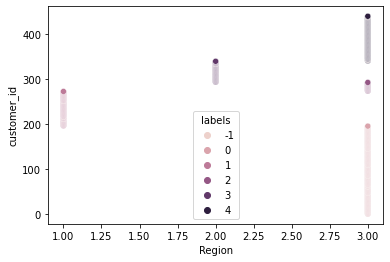

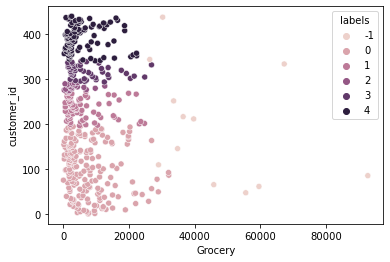

In [18]:
sns.scatterplot(df.Region, df.customer_id, hue=df.labels)
plt.show()

sns.scatterplot(df.Grocery, df.customer_id, hue=df.labels)
plt.show()


Text(0.5, 0, 'Grocery')

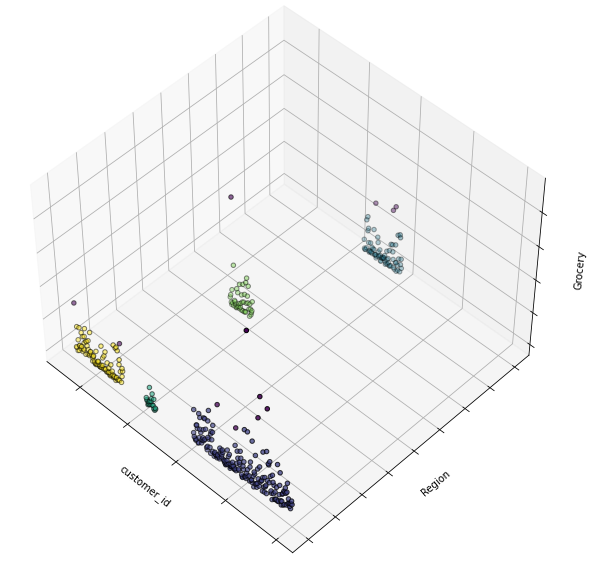

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.customer_id, df.Region, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('customer_id')
ax.set_ylabel('Region')
ax.set_zlabel('Grocery')
